In [2]:
import pandas as pd
import numpy as np
import os

# read preprocessed data
cwd = os.getcwd()
df = pd.read_csv(cwd + "/data_csv/preprocessing_data.csv", index_col=[0])
print(df)

                            image    emotion
0          Aaron_Peirsol_0003.jpg  HAPPINESS
1           Aaron_Sorkin_0001.jpg  HAPPINESS
2           Aaron_Sorkin_0002.jpg  HAPPINESS
3       Abbas_Kiarostami_0001.jpg    NEUTRAL
4     Abdel_Madi_Shabneh_0001.jpg    NEUTRAL
...                           ...        ...
4809      Zoran_Djindjic_0001.jpg    NEUTRAL
4810      Zoran_Djindjic_0002.jpg    NEUTRAL
4811      Zorica_Radovic_0001.jpg    NEUTRAL
4812      Zulfiqar_Ahmed_0001.jpg    NEUTRAL
4813     Zurab_Tsereteli_0001.jpg  HAPPINESS

[4814 rows x 2 columns]


In [3]:
def get_distance(fist_point, second_point):
    distance =  math.sqrt(math.pow(fist_point[0] - second_point[0], 2) + math.pow(fist_point[1] - second_point[1], 2))
    return abs(distance)

In [4]:
import cv2, math, numpy as np, dlib
from imutils import face_utils

# emotion list
# emotions = [0, 1, 2, 3, 4, 5] 
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(cwd + "/predictor/shape_predictor_68_face_landmarks.dat")

error = []
mlist = []
distlist = []
eye_size_list = []
eye_brows_list = []
# run each row in train.csv
for idx, row in df.iterrows():
    imagePath = cwd + "/cleaned_images/" + row.image
    image = cv2.imread(imagePath)

    rects = detector(image, 0)

    if len(rects) == 0:
        error.append(row.image)

    xlist = []
    ylist = []
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks and convert the facial landmark (x, y)
        shape = predictor(image, rect)
        shape = face_utils.shape_to_np(shape)

        # loop over coordinates, draw them on the image and store coordinates in two lists
        for (x, y) in shape:
            cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
            xlist.append(x)
            ylist.append(y)

    # get mean of both axes to determine centre of gravity
    xmean = np.mean(xlist) 
    ymean = np.mean(ylist)

    # plot central face on image
    cv2.circle(image, (int(xmean), int(ymean)), 1, (0, 255, 0), -1)

    # find distance between mouth
    # mavg = np.mean([
    #     get_distance([xlist[61], ylist[61]], [xlist[65], ylist[65]]) +
    #     get_distance([xlist[62], ylist[62]], [xlist[66], ylist[66]]) +
    #     get_distance([xlist[63], ylist[63]], [xlist[67], ylist[67]])
    # ])
    mavg = np.mean([
        ylist[61] - ylist[67],
        ylist[62] - ylist[66],
        ylist[63] - ylist[65] 
    ])
    mlist.append(mavg)

    left_eye_avg = np.mean([
        # get_distance([xlist[36], ylist[36]], [xlist[39], ylist[39]]),
        get_distance([xlist[37], ylist[37]], [xlist[40], ylist[40]]),
        get_distance([xlist[38], ylist[38]], [xlist[41], ylist[41]])
    ])

    # find distance between right eye
    right_eye_avg = np.mean([
        # get_distance([xlist[42], ylist[42]], [xlist[45], ylist[45]]),
        get_distance([xlist[43], ylist[43]], [xlist[46], ylist[46]]),
        get_distance([xlist[44], ylist[44]], [xlist[47], ylist[47]])
    ])
    eye_size_list.append(left_eye_avg + right_eye_avg)


    eye_brows = (ylist[24] - ylist[26]) + (ylist[19] - ylist[17])
    eye_brows_list.append(eye_brows)

    # find distance between every poin to central point
    templist = []
    for i in range(17, 68):
        dist = math.sqrt(math.pow(xlist[i] - xmean, 2) + math.pow(ylist[i] - ymean, 2))
        templist.append(dist)
    distavg = np.mean(dist)
    distlist.append(distavg)
  
    # show the output image with the face detections + facial landmarks
    cv2.imshow("Output", image)# 
    k = cv2.waitKey(5) & 0xFF
    if k == 68:
        break

print(len(error))

0


In [5]:
# add feature to df
df['mouth_distance'] = mlist
df['average_distance'] = distlist
df['eye_brows'] = eye_brows_list
df['eye_size'] = eye_size_list

# replace string emotion label with integer
dictionary = {'emotion':{'HAPPINESS': 0,'NEUTRAL': 1, 'SURPRISE': 2, 'ANGER': 3, 'SADNESS': 4, 'DISGUST': 5}}
df.replace(dictionary, inplace = True)
df.to_csv(cwd + "/data_csv/preprocessing_data.csv", index=False)

In [6]:
from matplotlib import pyplot as plt
def scree_plot(X, n_components, with_cumulative=False, show_data_label=False, figsize=(10, 7)):
    '''
    PCA scree plot with cumulative
    '''
    scaler = StandardScaler()
    X_t=scaler.fit_transform(X)

    max_components = min(X.shape)
    x=np.arange(1, n_components+1)
    pca = PCA(n_components=max_components)
    pca.fit_transform(X_t)
    y1=pca.explained_variance_ratio_[:n_components]
    y2=np.cumsum(pca.explained_variance_ratio_)[:n_components]
    
    plt.figure(figsize=figsize)
    
    if n_components > 20:
        marker = None
    else:
        marker = 'o'
    if with_cumulative:
        plt.plot(x, y2, linestyle='--', marker=marker, label='cumulative', color='salmon')
        
    plt.plot(x, y1, linestyle='-', marker=marker, label='individual', color='deepskyblue')
    plt.title('explained variance ratio')
    plt.xlabel('Number of components')
    plt.ylabel('proportion of variance explained')
    plt.legend()
    if with_cumulative:
        [plt.axhline(y=xl, color='.7', linestyle='--') for xl in [.8, .9, .95, 1]]
    plt.grid(axis='x')

    if show_data_label:
        for n, v, cv in zip(np.nditer(x, flags=['refs_ok']), 
                            np.nditer(y1, flags=['refs_ok']),
                            np.nditer(y2, flags=['refs_ok'])):
                plt.text(n+.02, v+.02, f'{v*100:.2f}%', fontsize=10)
                if with_cumulative:
                    plt.text(n+.02, cv+.02, f'{cv*100:.2f}%', fontsize=10)

In [7]:
X = df[df.columns.difference(['Unnamed: 0', 'emotion', 'image'])]
X.corr()

,average_distance,eye_brows,eye_size,mouth_distance
average_distance,1.000000,0.267317,0.195736,0.655891
eye_brows,0.267317,1.000000,0.045189,-0.009775
eye_size,0.195736,0.045189,1.000000,-0.033915
mouth_distance,0.655891,-0.009775,-0.033915,1.000000


(4, 4)


,PC1,PC2,PC3,PC4
average_distance,-0.710300,0.002700,-0.017700,-0.703700
eye_brows,-0.263400,0.583600,0.726400,0.249800
eye_size,-0.178000,0.681800,-0.681000,0.199500
mouth_distance,-0.628000,-0.441100,-0.091500,0.634600


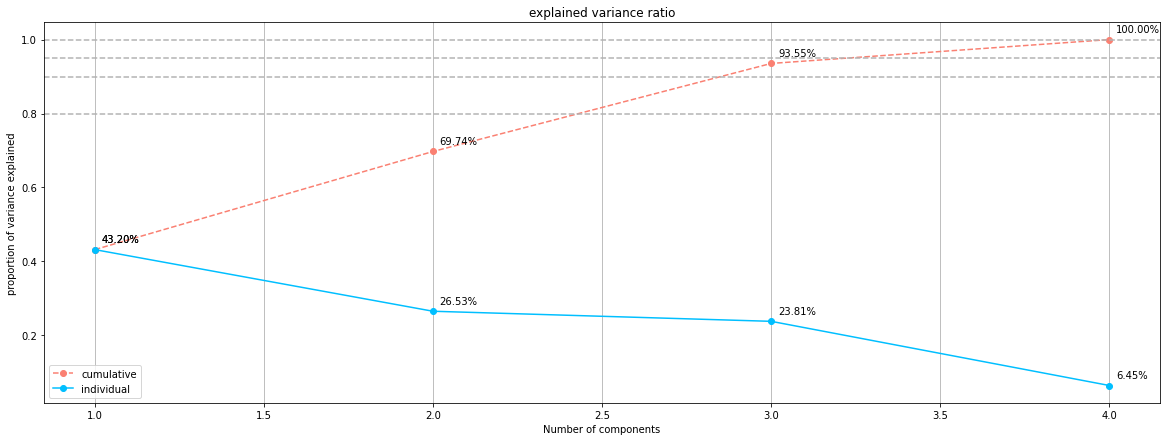

In [8]:
# Plot PCA Graph

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pca = PCA(n_components=4)
X_t = scaler.fit_transform(X)
pca.fit_transform(X_t)
scree_plot(X, 4, True, True, (20 , 7))
cols=['average_distance', 'eye_brows', 'eye_size', 'mouth_distance']
print(pca.components_.shape)
dpc=pd.DataFrame(pca.components_.T, 
                  index=cols, 
                  columns=[f'PC{n+1}' for n in range(pca.components_.shape[0])]).round(4) #Eigenvectors
                  
# dpc
dpc.style.applymap(lambda e: 'background-color: gray' if e > .5 else 'background-color: dark-white')